### Predictive Power of LMs

In [4]:
all_data <- read.csv("surprisal_data/combined_surprisal_rts.csv")

Fiting models for eyetracking data (Dundee corpus). To account for spillover effects, we use the previous tokens' features as predictors.

In [9]:
et_control_formula <- 'rt ~ log_freq * word_length + prev_freq_1 * prev_len_1'
et_surprisal_formula <- 'rt ~ surprisal + prev_surprisal_1 + log_freq * word_length + prev_freq_1 * prev_len_1'

In [12]:
predictive_power <- function(data, control_formula, surprisal_formula) {
    control_model <- glm(control_formula, data, family = 'gaussian')
    surprisal_model <- glm(surprisal_formula, data, family = 'gaussian')
    print(summary(surprisal_model))
    (logLik(surprisal_model) - logLik(control_model)) / nrow(data)
}

In [51]:
dundee_et <- all_data[all_data$corpus == "dundee",]
dundee_orth <- dundee_et[dundee_et$tokenization == "orthographic", ]
dundee_bpe <- dundee_et[dundee_et$tokenization == "bpe", ]
dundee_morph <- dundee_et[dundee_et$tokenization == "morphological", ]

In [52]:
dundee_predictive_power <- data.frame(
    orthographic=predictive_power(dundee_orth, et_control_formula, et_surprisal_formula),
    bpe=predictive_power(dundee_bpe, et_control_formula, et_surprisal_formula),
    morphological=predictive_power(dundee_morph, et_control_formula, et_surprisal_formula)
)



Call:
glm(formula = surprisal_formula, family = "gaussian", data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-261.31   -39.06    -6.36    33.01   796.86  

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            226.5768     4.2446  53.379  < 2e-16 ***
surprisal                2.3165     0.1188  19.500  < 2e-16 ***
prev_surprisal_1         2.1489     0.1168  18.395  < 2e-16 ***
log_freq                 7.3587     0.9891   7.439 1.03e-13 ***
word_length             -0.9833     0.6898  -1.426    0.154    
prev_freq_1              7.0204     0.9852   7.126 1.06e-12 ***
prev_len_1              -8.8801     0.6978 -12.726  < 2e-16 ***
log_freq:word_length    -2.7185     0.1667 -16.308  < 2e-16 ***
prev_freq_1:prev_len_1  -0.9597     0.1690  -5.678 1.37e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 4732.453)

    Null deviance: 22872

Running the same analyses for the Natural Stories corpus. The only major difference is that this corpus reports self-paced reading times, where spillover effects occur over the previous three words.

In [53]:
spr_control_formula <- 'rt ~ log_freq * word_length + prev_freq_1 * prev_len_1 + prev_freq_2 * prev_len_2 + prev_freq_3 * prev_len_3'

spr_surprisal_formula <- 'rt ~ surprisal + prev_surprisal_1 + prev_surprisal_2 + prev_surprisal_3 + log_freq * word_length + prev_freq_1 * prev_len_1 + prev_freq_2 * prev_len_2 + prev_freq_3 * prev_len_3'

In [54]:
natural_stories_spr <- all_data[all_data$corpus == "natural_stories", ]
natural_stories_orth <- natural_stories_spr[natural_stories_spr$tokenization == "orthographic", ]
natural_stories_bpe <- natural_stories_spr[natural_stories_spr$tokenization == "bpe", ]
natural_stories_morph <- natural_stories_spr[natural_stories_spr$tokenization == "morphological", ]

In [44]:
natural_stories_predictive_power <- data.frame(
    orthographic=predictive_power(natural_stories_orthographic, spr_control_formula, spr_surprisal_formula),
    bpe=predictive_power(natural_stories_bpe, spr_control_formula, spr_surprisal_formula),
    morphological=predictive_power(natural_stories_morph, spr_control_formula, spr_surprisal_formula)
)



Call:
glm(formula = surprisal_formula, family = "gaussian", data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-75.400  -19.930   -4.616   14.836  277.086  

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            322.12769    7.01034  45.950  < 2e-16 ***
surprisal                0.91267    0.12000   7.606 3.24e-14 ***
prev_surprisal_1         0.70238    0.12111   5.800 6.96e-09 ***
prev_surprisal_2         0.24169    0.11609   2.082 0.037387 *  
prev_surprisal_3         0.33941    0.11356   2.989 0.002811 ** 
log_freq                 4.02679    1.05055   3.833 0.000128 ***
word_length             -4.10154    0.78499  -5.225 1.80e-07 ***
prev_freq_1              2.04327    1.08799   1.878 0.060422 .  
prev_len_1              -2.34998    0.80892  -2.905 0.003684 ** 
prev_freq_2             -0.34790    1.04622  -0.333 0.739495    
prev_len_2               0.26049    0.79917   0.326 0.744467    
prev_freq_3      

The tables report the per-token $\Delta LogLik$. These show that incorporating surprisal into the control models improved their ability to predict reading times.

In [45]:
dundee_predictive_power

orthographic,bpe,morphological
<dbl>,<dbl>,<dbl>
0.01034982,0.010752,0.01025458


In [46]:
natural_stories_predictive_power

orthographic,bpe,morphological
<dbl>,<dbl>,<dbl>
0.008818827,0.01001237,0.008580439


This is in line with the values from Wilcox et al (2020), but there does not seem to be a major difference between the models' predictive power. 

These metrics are reported for the entire dataset, so we now evaluate regression models against held-out data. For each model, we now report $\Delta LogLik$ for each run of 10-fold cross-validation.

In [36]:
test_data_loglik <- function(model, test_data) {
    predictions <- predict(model, test_data)
    stdev <- sigma(model)
    dnorm(test_data$rt, predictions, stdev, log = TRUE)
}

In [48]:
cross_validate <- function(data, indices, control_formula, surprisal_formula) {
    data<-data[indices,]
    folds <- cut(seq(1,nrow(data)),breaks=10,labels=FALSE) # this is the same for each model
    predictive_power <- seq(1:10)
    for(i in 1:10){
        test_indices <- which(folds==i)
        test_data <- data[test_indices, ]
        train_data <- data[-test_indices, ]
        fold_control_model <- glm(control_formula, train_data, family = 'gaussian')
        fold_surprisal_model <- glm(surprisal_formula, train_data, family = 'gaussian')
        surprisal_diff <- test_data_loglik(fold_surprisal_model, test_data) - test_data_loglik(fold_control_model, test_data)
        predictive_power[i] <- mean(surprisal_diff) # summed per-token log likelihoods, divided by number of tokens 
        }
    predictive_power
}

In [61]:
corpus_cv <- function(orth_data, bpe_data, morph_data, control_formula, surprisal_formula) {
    shuffled_indices <- sample(nrow(orth_data))
    cv_results <- data.frame(
      orthographic = cross_validate(orth_data, shuffled_indices, control_formula, surprisal_formula),
       bpe = cross_validate(bpe_data, shuffled_indices, control_formula, surprisal_formula),
       morphological = cross_validate(morph_data, shuffled_indices, control_formula, surprisal_formula)
    )
    cv_results
}

In [70]:
dundee_cv_results <- corpus_cv(dundee_orth, dundee_bpe, dundee_morph, et_control_formula, et_surprisal_formula)
natural_stories_cv_results <- corpus_cv(natural_stories_orth, natural_stories_bpe, natural_stories_morph,
                                        spr_control_formula, spr_surprisal_formula)

In [63]:
library(ggplot2)
library(reshape2)

No id variables; using all as measure variables



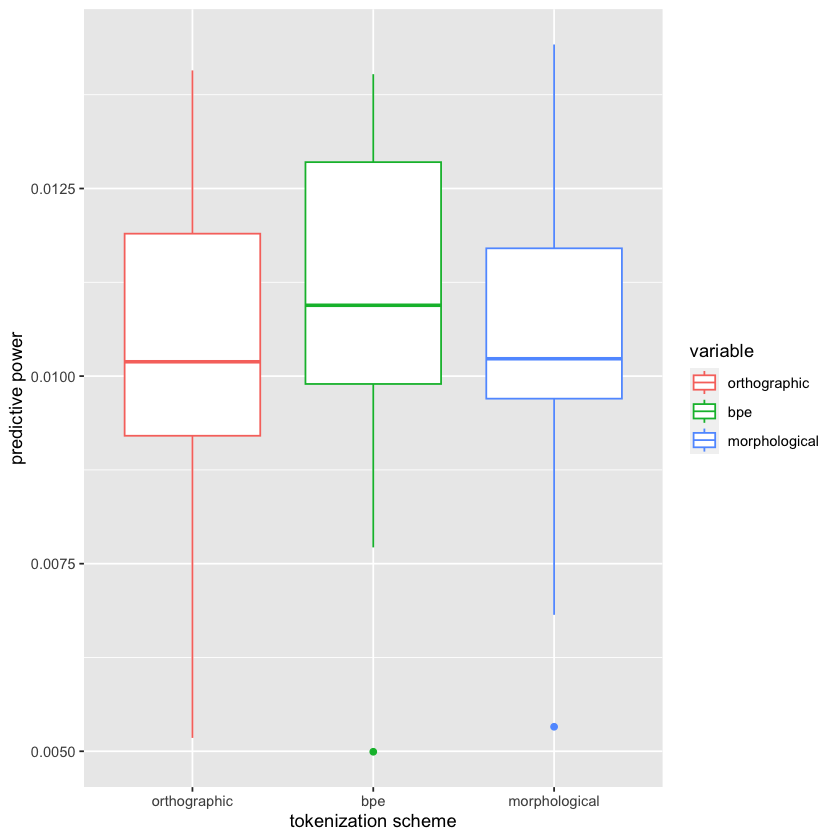

In [64]:
ggplot(melt(dundee_cv_results))+ geom_boxplot(aes(x = variable, y = value, color = variable)) + labs(y="predictive power",
                                                                            x = "tokenization scheme")

No id variables; using all as measure variables



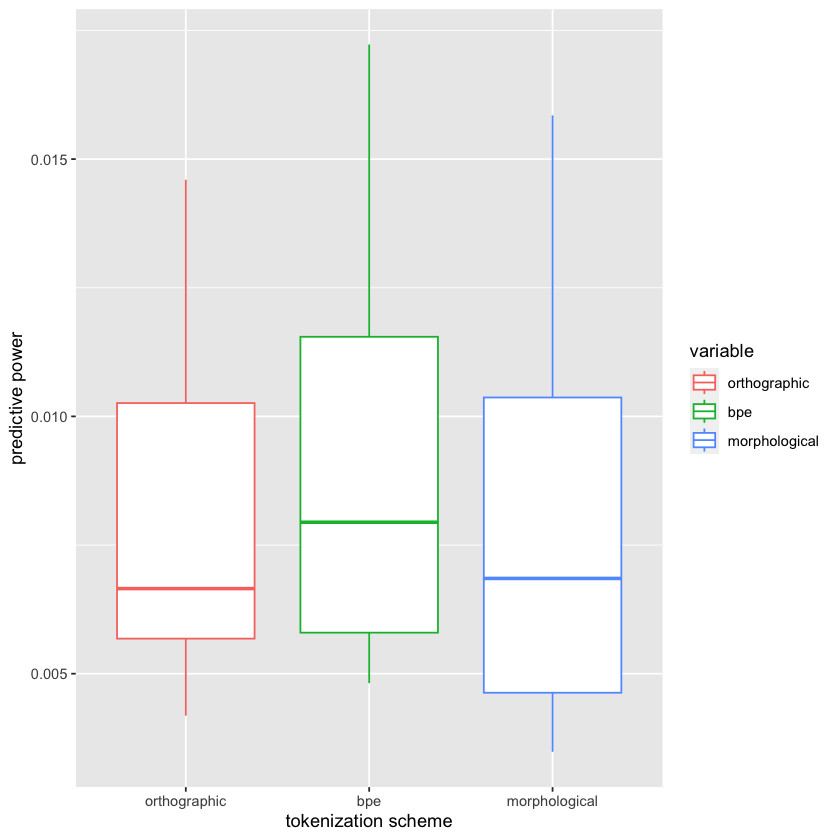

In [74]:
ggplot(melt(natural_stories_cv_results))+ geom_boxplot(aes(x = variable, y = value, color = variable)) + labs(y="predictive power",
                                                                            x = "tokenization scheme")

Testing for statistical significance. We use a nonparametric test since we have 10 datapoints and the models were fit independently of one another. A p-value should show there is no statistically significant difference between the $\Delta LogLik$ estimated for the folds for each tokenization method.

Dundee

In [66]:
wilcox.test(dundee_cv_results$orthographic, dundee_cv_results$bpe)


	Wilcoxon rank sum exact test

data:  dundee_cv_results$orthographic and dundee_cv_results$bpe
W = 44, p-value = 0.6842
alternative hypothesis: true location shift is not equal to 0


In [69]:
wilcox.test(dundee_cv_results$orthographic, dundee_cv_results$morphological)


	Wilcoxon rank sum exact test

data:  dundee_cv_results$orthographic and dundee_cv_results$morphological
W = 49, p-value = 0.9705
alternative hypothesis: true location shift is not equal to 0


Natural Stories 

In [71]:
wilcox.test(natural_stories_cv_results$orthographic, natural_stories_cv_results$bpe)


	Wilcoxon rank sum exact test

data:  natural_stories_cv_results$orthographic and natural_stories_cv_results$bpe
W = 43, p-value = 0.6305
alternative hypothesis: true location shift is not equal to 0


In [72]:
wilcox.test(natural_stories_cv_results$orthographic, natural_stories_cv_results$morphological)


	Wilcoxon rank sum exact test

data:  natural_stories_cv_results$orthographic and natural_stories_cv_results$morphological
W = 53, p-value = 0.8534
alternative hypothesis: true location shift is not equal to 0


### Slowdown in reading time due to surprisal 

Replicating the qualitative results from Wilcox et al (2020) on the relationship between surprisal and reading time. For each LM, we fit a generalized additive model and plot the slowdown in reading time due to surprisal. The plotting functionality with the `mgcViz` library was not compatible with other `ggplot`-based tools to make a figure with a grid.

In [274]:
library(mgcViz)

In [275]:
plot_gam <- function(data, color_index, plot_title) {
    rt_surprisal_gam <- gam(rt ~ s(surprisal, bs = "cr", k = 20) + s(prev_surprisal_1, bs = "cr", k = 20) 
            + s(prev_surprisal_2, bs = 'cr', k = 20) + s(prev_surprisal_3, bs = 'cr', k = 20)
            + te(log_freq, word_length, bs = "cr") + te(prev_freq_1, prev_len_1, bs = "cr") 
            + te(prev_freq_2, prev_len_2, bs = 'cr') + te(prev_freq_3, prev_len_3, bs = 'cr'), data=data)
    # formula from pg 3 of https://arxiv.org/pdf/2006.01912.pdf (Wilcox et al 2020)
    plot(getViz(rt_surprisal_gam), select = 1, xlab = "surprisal", ylab = "slowdown") + l_fitLine(color = color_index) + l_ciLine(color = color_index) + 
    theme_get() + labs(x = "Surprisal", y = "Speedup in Reading Time (ms)", title = plot_title)
}



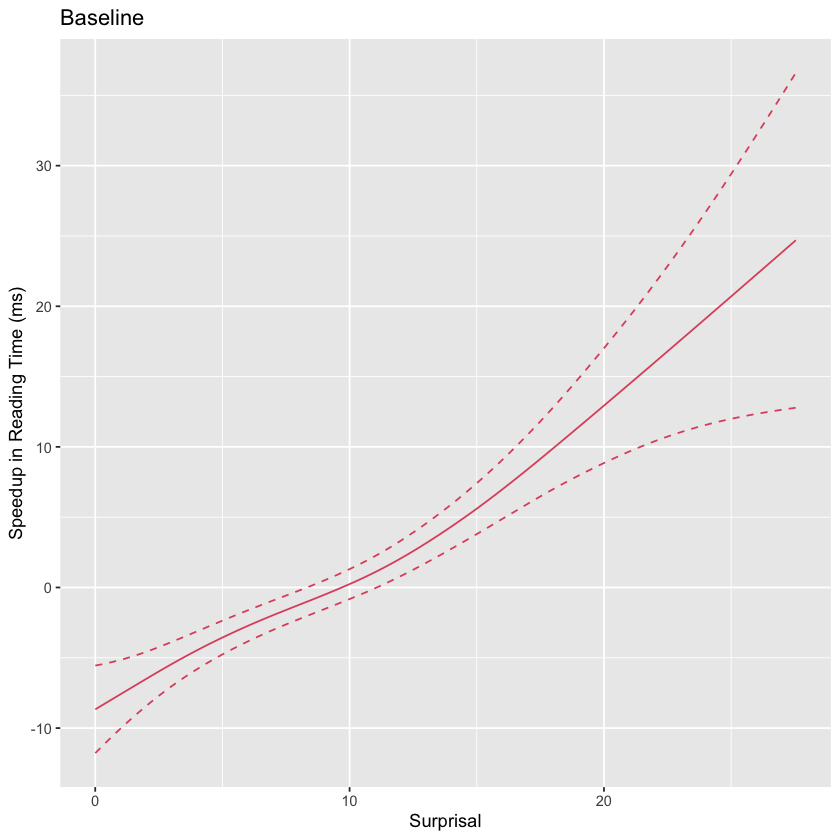

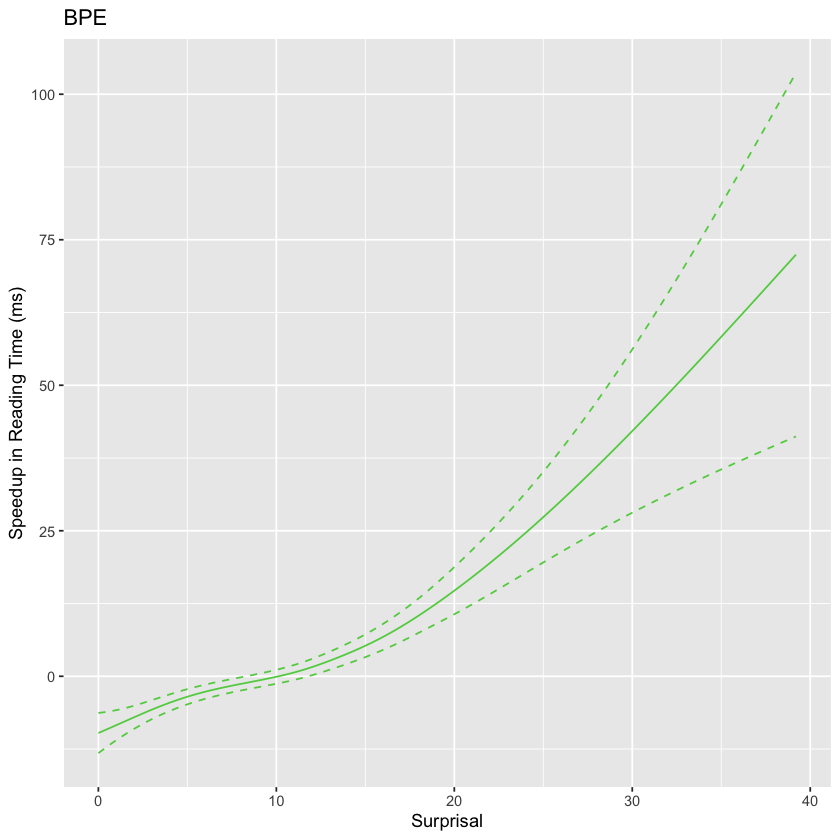

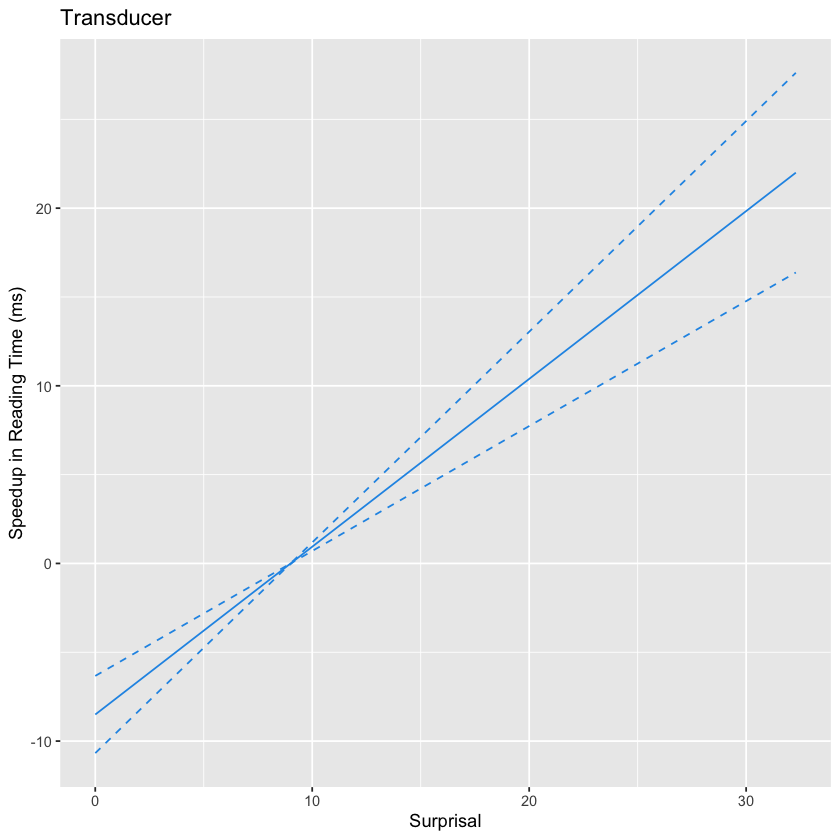

In [276]:
plot_gam(baseline_data, 2, "Baseline")
plot_gam(bpe_data, 3, "BPE")
plot_gam(transducer_data, 4, "Transducer")